In [84]:
import pandas as pd
import pickle
from datasets import Dataset
import torch
from datasets import DatasetDict
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from sklearn.metrics import confusion_matrix


In [17]:
label_encoding = {
    0: "Deliberation",
    1: "Imaginative entry",
    2: "Other",
    3: "Procedure",
    4: "Seminar",
    5: "Social",
    6: "UX",
}

In [3]:
# Load model
PATH = 'baseline_bert_3_8_base_cased'
tokenizer = BertTokenizer.from_pretrained(PATH, local_files_only=True)
model = BertForSequenceClassification.from_pretrained(PATH, local_files_only=True)



# Bert base test misspredictions

In [56]:
# Get wrong predictions, also return the text, true label and predicted label
def get_wrong_predictions(model, tokenizer, test_data, test_label):
    model.eval()
    predictions = []
    for i in range(len(test_data)):
        text = test_data[i]
        label = test_label[i]
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        predictions.append(np.argmax(logits))
    wrong_predictions = []
    test_labels = []
    preds = []
    for i in range(len(predictions)):
        if predictions[i] != test_label[i]:
            wrong_predictions.append(test_data[i])
            test_labels.append(test_label[i])
            preds.append(predictions[i])
    return wrong_predictions, test_labels, preds



# Load data
train_df = pd.read_pickle("train_dataset")
test_df = pd.read_pickle("test_dataset")
val_df = pd.read_pickle("val_dataset")

dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'test': Dataset.from_pandas(test_df),
    'val': Dataset.from_pandas(val_df)
})

# Add test dataset
test_data = dataset['test']['text']
test_label = dataset['test']['label']

# Add validation dataset
val_data = dataset['val']['text']
val_label = dataset['val']['label']

# TODO: Add Train data in dataset or not?



# Join test and val data
data = test_data + val_data
labels = test_label + val_label

wrong_predictions, labels, preds = get_wrong_predictions(model, tokenizer, data, labels)

# Use label encoding to get the label names
labels_name = [label_encoding[label] for label in labels]
preds_name = [label_encoding[pred.item()] for pred in preds]



In [64]:
print(f"Length of all data: {len(dataset['val']) + len(dataset['test']) + len(dataset['train'])}, wrong predictions in test and validation dataset: {len(wrong_predictions)}")

Length of all data: 611, wrong predictions in test and validation dataset: 50


In [47]:
for text_pred, label, pred in zip(wrong_predictions, labels_name, preds_name):
    if len(text_pred) > 20:
        continue
        
    
    print(f"Text: {text_pred}")
    print(f"True label: {label}")
    print(f"Predicted label: {pred}")
    print("\n")



Text: I like it
True label: Deliberation
Predicted label: Seminar


Text: Submitted
True label: Deliberation
Predicted label: Social


Text: w
True label: Other
Predicted label: Seminar


Text: And that's true! 
True label: Imaginative entry
Predicted label: Seminar


Text: Good idea.
True label: Seminar
Predicted label: Social


Text: I am on,
True label: Procedure
Predicted label: Deliberation


Text: I couldn't either.
True label: Procedure
Predicted label: Seminar


Text: it's wonderful!
True label: Seminar
Predicted label: Social


Text: ok
True label: Deliberation
Predicted label: Social


Text: ooooh
True label: UX
Predicted label: Social




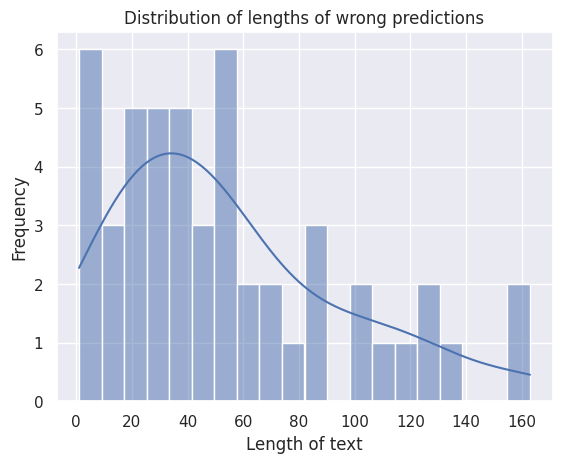

In [118]:
# Plot distribution of lengths of wrong predictions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
lengths = [len(text) for text in wrong_predictions]
sns.histplot(lengths, kde=True, bins=20)
plt.title("Distribution of lengths of wrong predictions")

# Add xticts based on bin width
bin_width = 20
plt.xticks(np.arange(0, max(lengths), bin_width))


plt.xlabel("Length of text")
plt.ylabel("Frequency")

# Save plot
plt.savefig("../images/wrong_predictions_length_distribution.pdf")


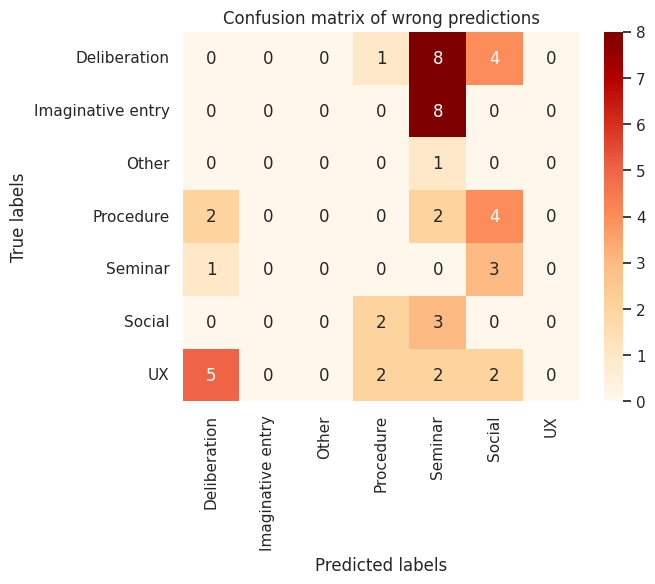

In [119]:
# Construct confusion matrix
cm = confusion_matrix(labels_name, preds_name, labels=list(label_encoding.values()))

sns.heatmap(cm, annot=True, xticklabels=list(label_encoding.values()), yticklabels=list(label_encoding.values()), cmap='OrRd')
# Change xticts to be vertical
# Show cell text in other colors
plt.rcParams['text.color'] = 'red'

# Add predicted and expected labels
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix of wrong predictions")

# Save plot
plt.savefig("../images/confusion_matrix_wrong_predictions.pdf")